# K-Means for Hearing Threshold Data Clustering

`Each participant's both ears are treated as if they were two participants.`

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [2]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(9729, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0,5.0,20.0,50.0,55.0,60.0,55.0,60.0,53
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0,15.0,25.0,30.0,30.0,45.0,60.0,50.0,56
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0,15.0,10.0,15.0,25.0,15.0,25.0,20.0,42
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0,0.0,-5.0,0.0,5.0,-5.0,10.0,10.0,22


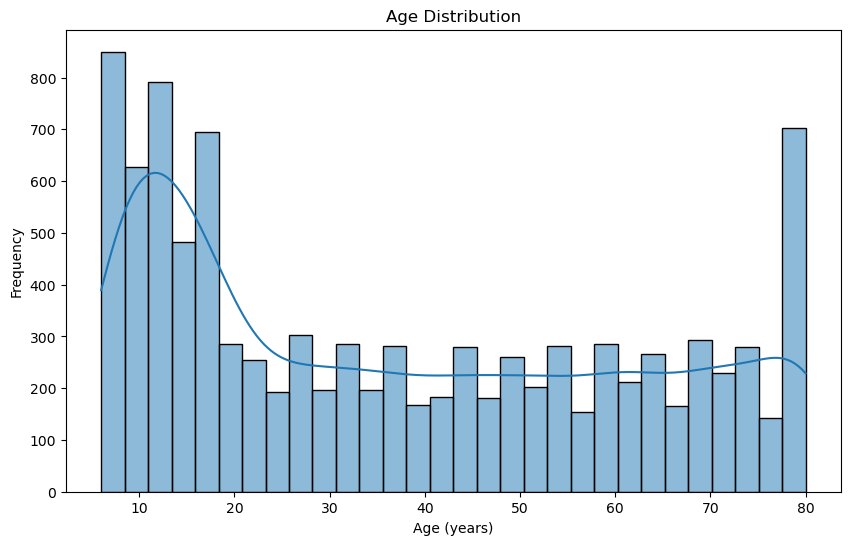

In [3]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis=0)

# Change the column names to be more descriptive

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124797,888.0,0.0,-5.0,888.0,5.0,888.0,10.0
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0
124811,35.0,30.0,15.0,30.0,25.0,55.0,60.0


In [5]:
# Process missing values
cleaned_ear_data = ear_data.replace({888: np.nan, 666: np.nan, '.': np.nan}, inplace=False)
cleaned_ear_data = cleaned_ear_data.dropna(inplace=False)
# cleaned_ear_data.reset_index(drop=True, inplace=True)

cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83733,10.0,15.0,40.0,55.0,60.0,55.0,65.0
83735,25.0,25.0,30.0,20.0,40.0,40.0,55.0
83736,10.0,10.0,10.0,15.0,10.0,15.0,20.0
83741,5.0,0.0,5.0,5.0,5.0,20.0,15.0
...,...,...,...,...,...,...,...
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124786,0.0,10.0,10.0,5.0,0.0,15.0,0.0
124787,20.0,10.0,5.0,5.0,5.0,10.0,5.0


In [6]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

# K-Means with raw data

KMeans with 2 clusters
Silhouette Score: 0.584
Davies Bouldin Score: 0.708
Calinski Harabasz Score: 25442.997
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.425
Davies Bouldin Score: 0.953
Calinski Harabasz Score: 20564.411
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.305
Davies Bouldin Score: 1.177
Calinski Harabasz Score: 17180.703
--------------------------------------------------


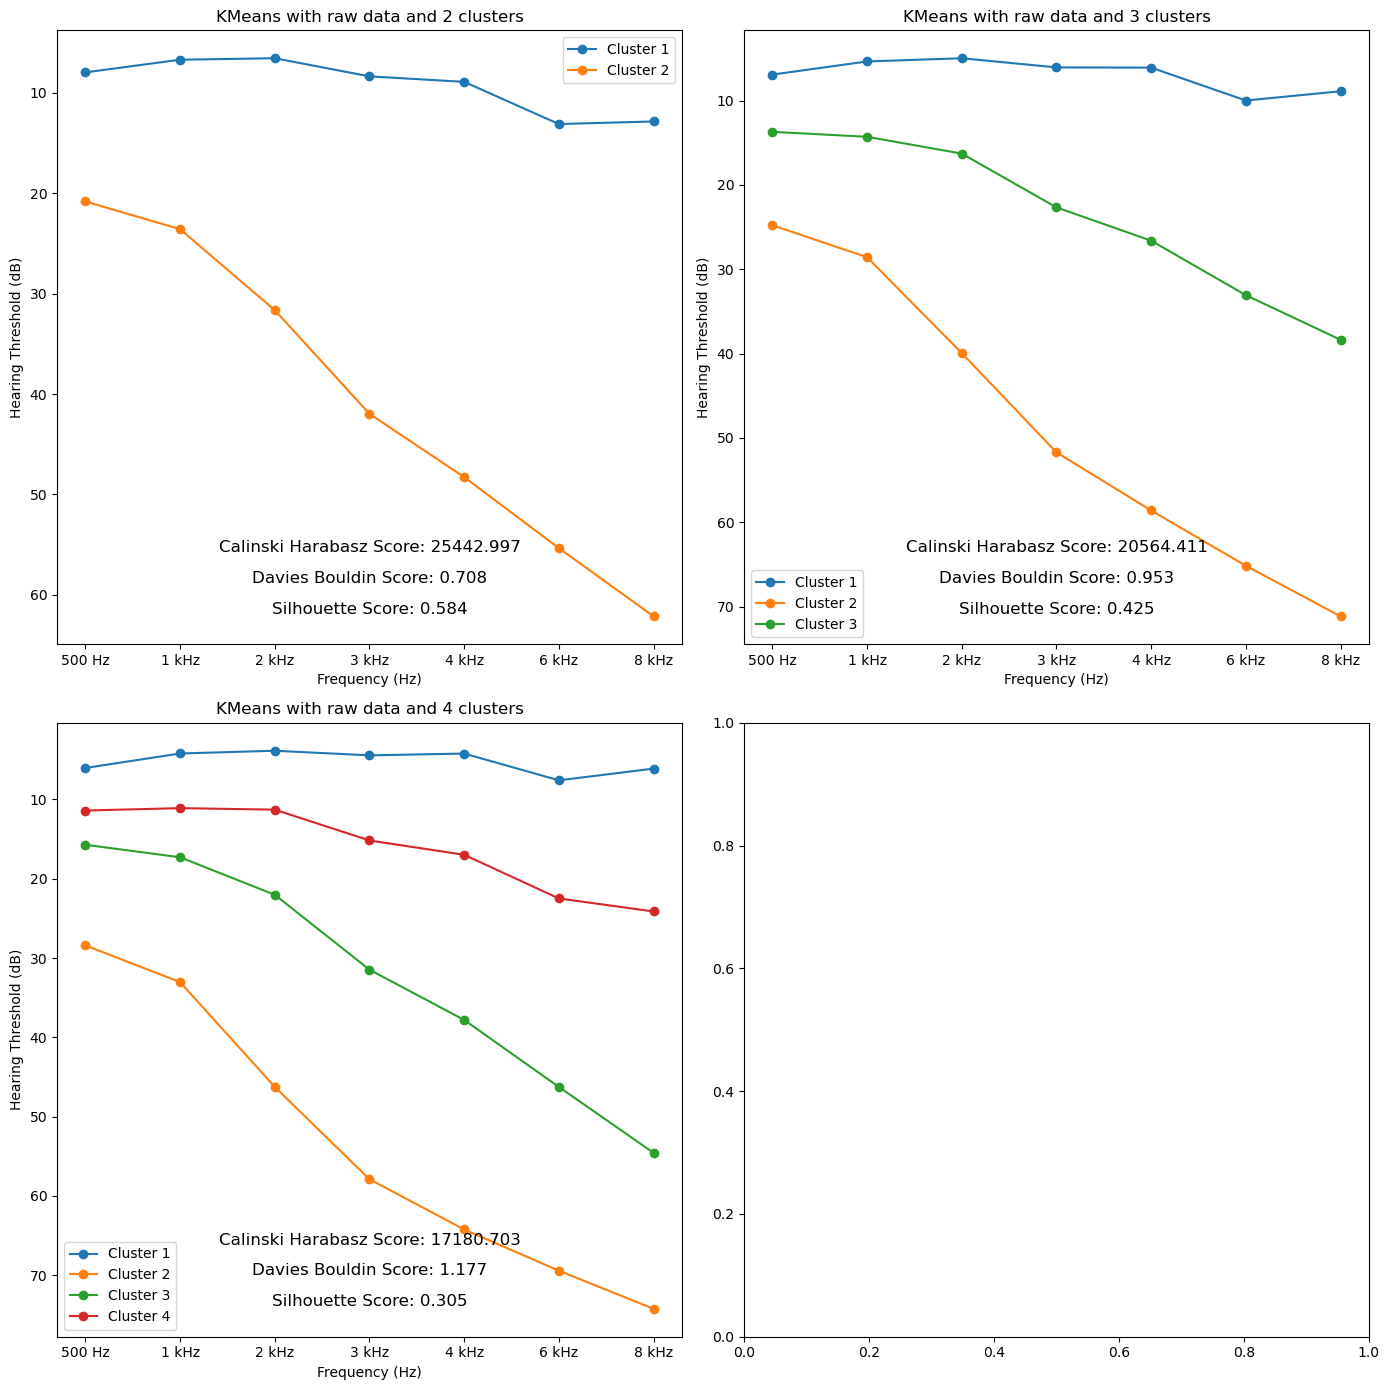

In [12]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(cleaned_ear_data)

    # Extract the centroids
    centroids = kmeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with raw data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with centered data

KMeans with 2 clusters
Silhouette Score: 0.579
Davies Bouldin Score: 0.712
Calinski Harabasz Score: 24198.106
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.435
Davies Bouldin Score: 0.962
Calinski Harabasz Score: 18823.904
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.308
Davies Bouldin Score: 1.258
Calinski Harabasz Score: 15310.475
--------------------------------------------------


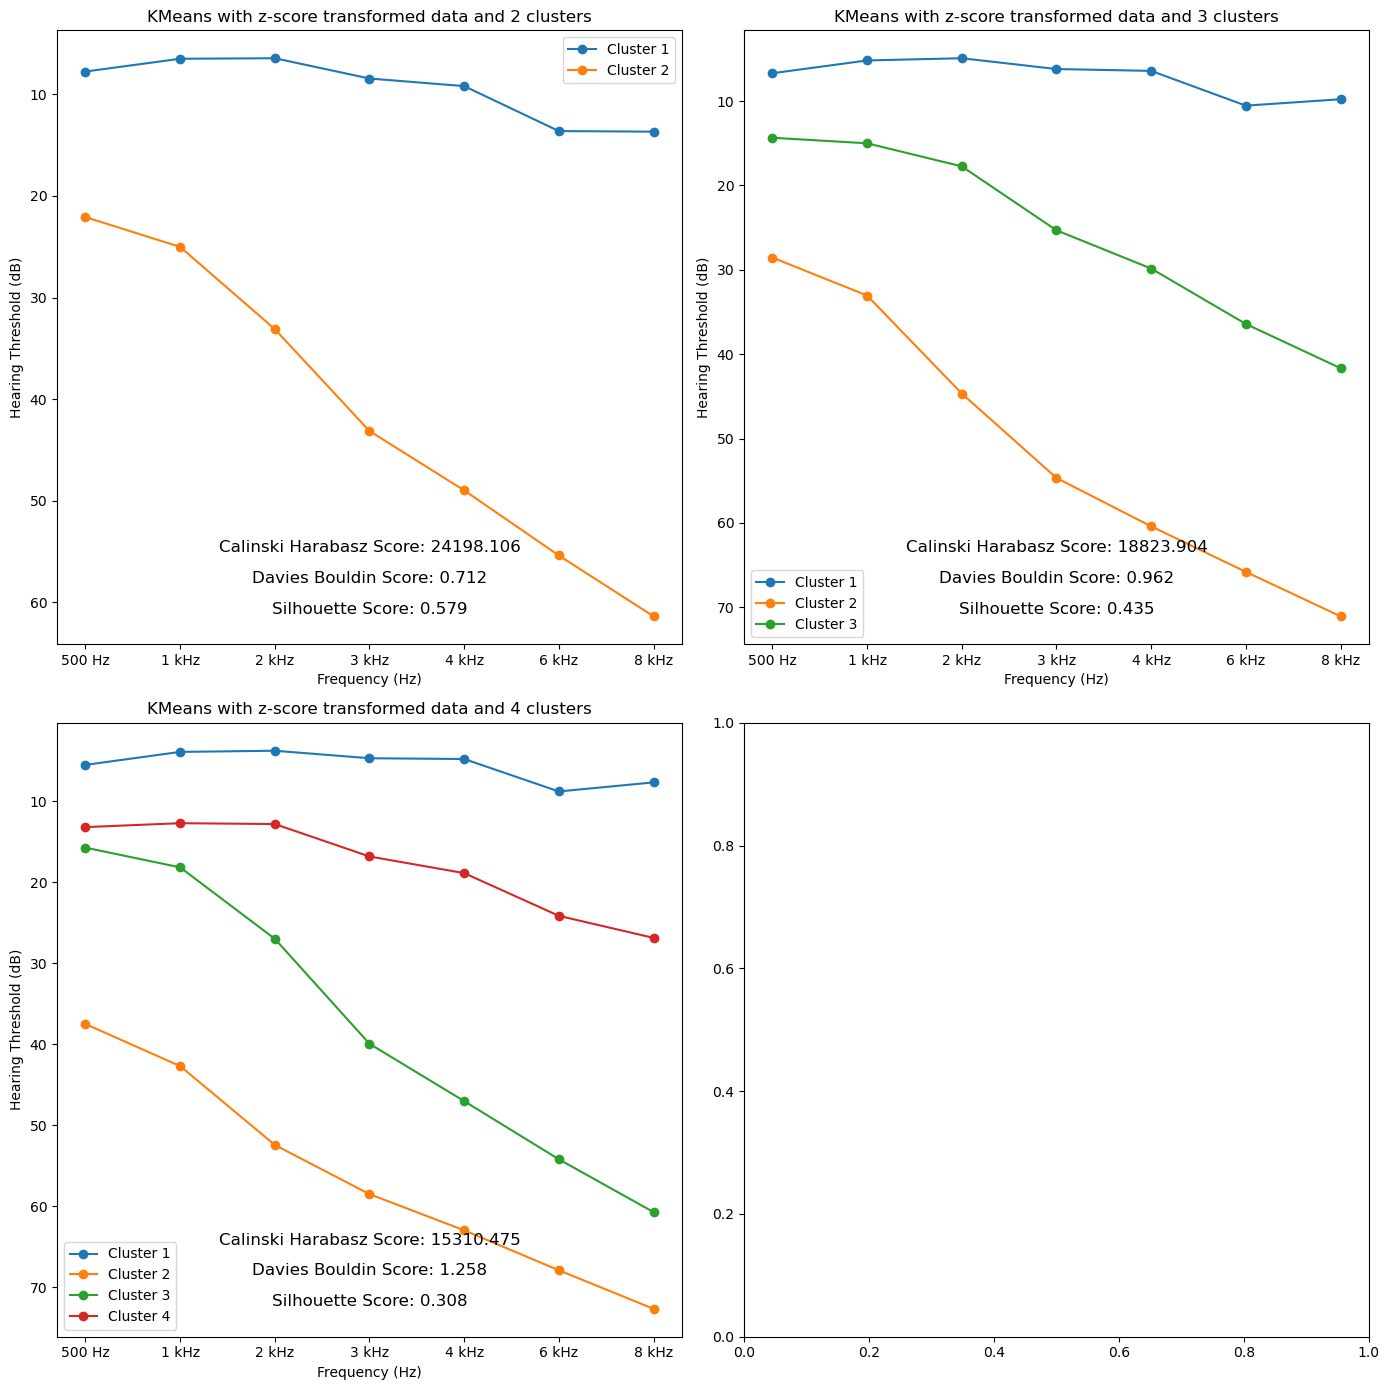

In [8]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(standard_scaled_data)

    # Extract the centroids
    centroids = standard_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with z-score transformed data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## KMeans with min-max standardized data

KMeans with 2 clusters
Silhouette Score: 0.583
Davies Bouldin Score: 0.709
Calinski Harabasz Score: 25425.883
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.424
Davies Bouldin Score: 0.954
Calinski Harabasz Score: 20548.814
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.313
Davies Bouldin Score: 1.168
Calinski Harabasz Score: 17146.683
--------------------------------------------------


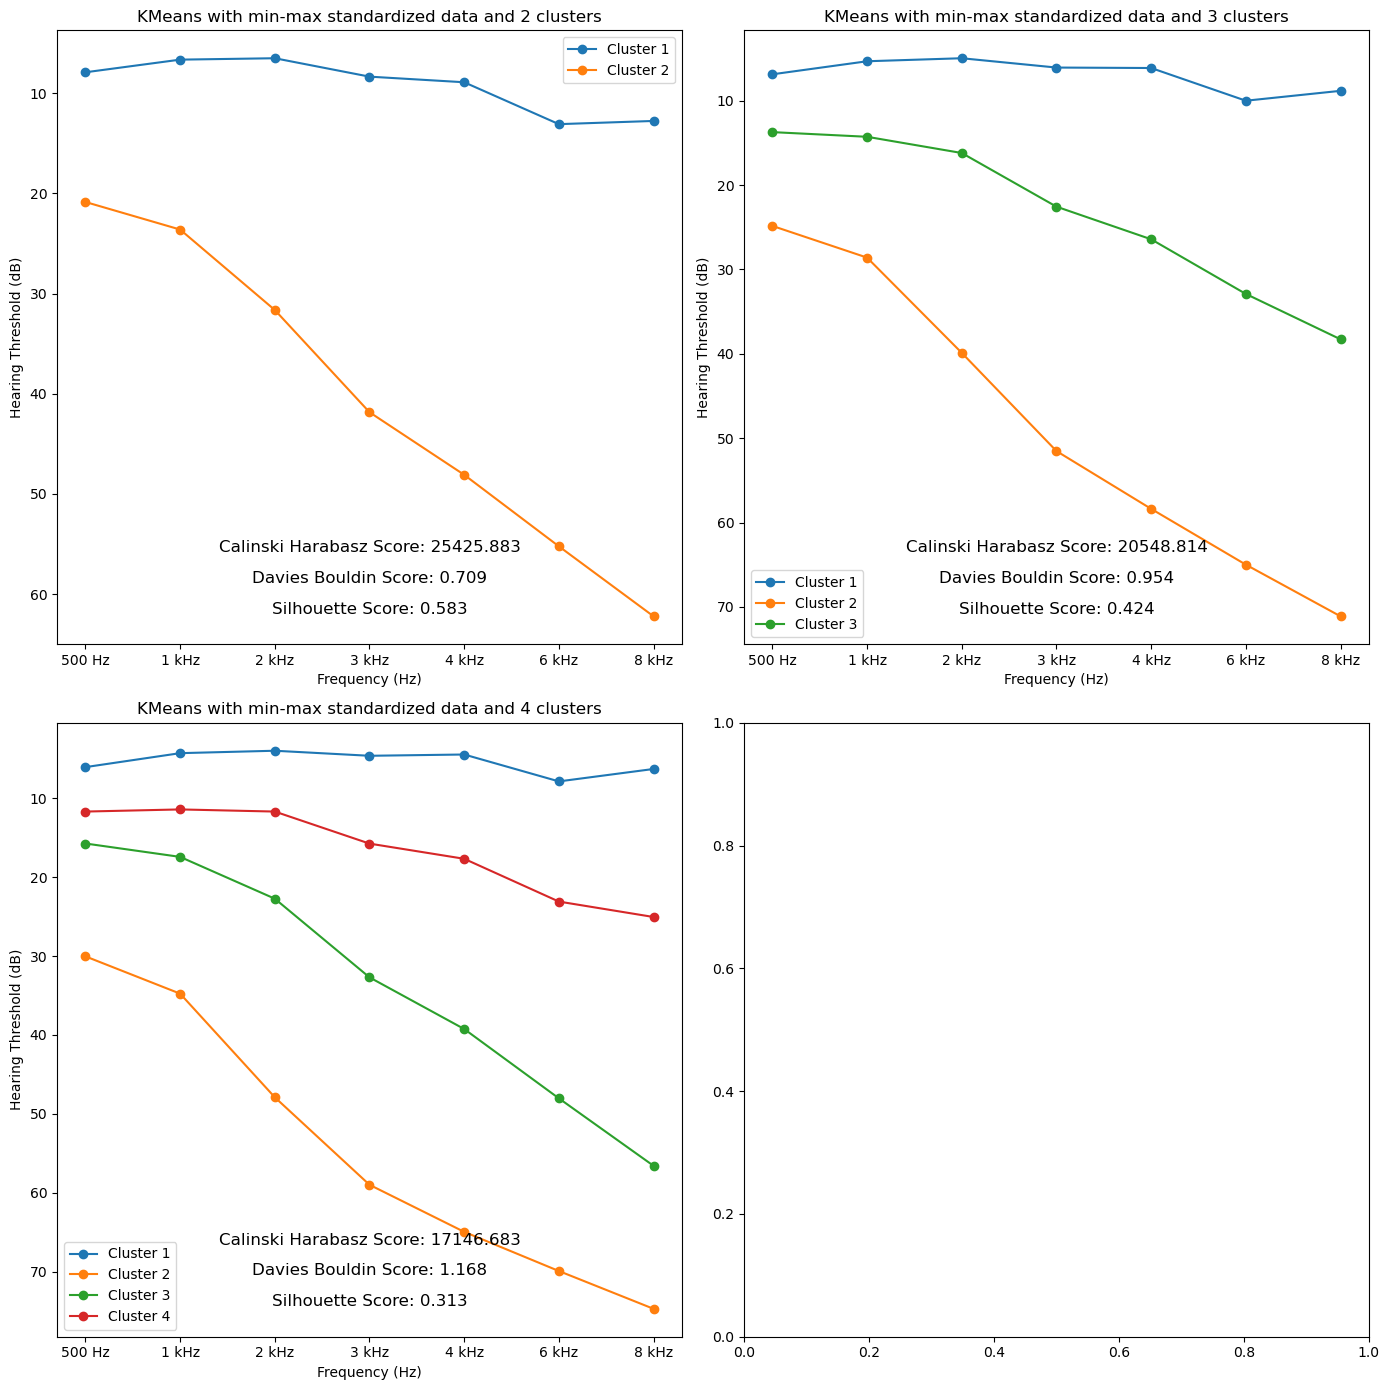

In [9]:
# K-Means with min-max standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(minmax_scaled_data)

    # Extract the centroids
    centroids = minmax_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with min-max standardized data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with robust scaled data

KMeans with 2 clusters
Silhouette Score: 0.566
Davies Bouldin Score: 0.725
Calinski Harabasz Score: 21550.667
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.425
Davies Bouldin Score: 1.009
Calinski Harabasz Score: 16574.027
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.295
Davies Bouldin Score: 1.306
Calinski Harabasz Score: 13446.200
--------------------------------------------------


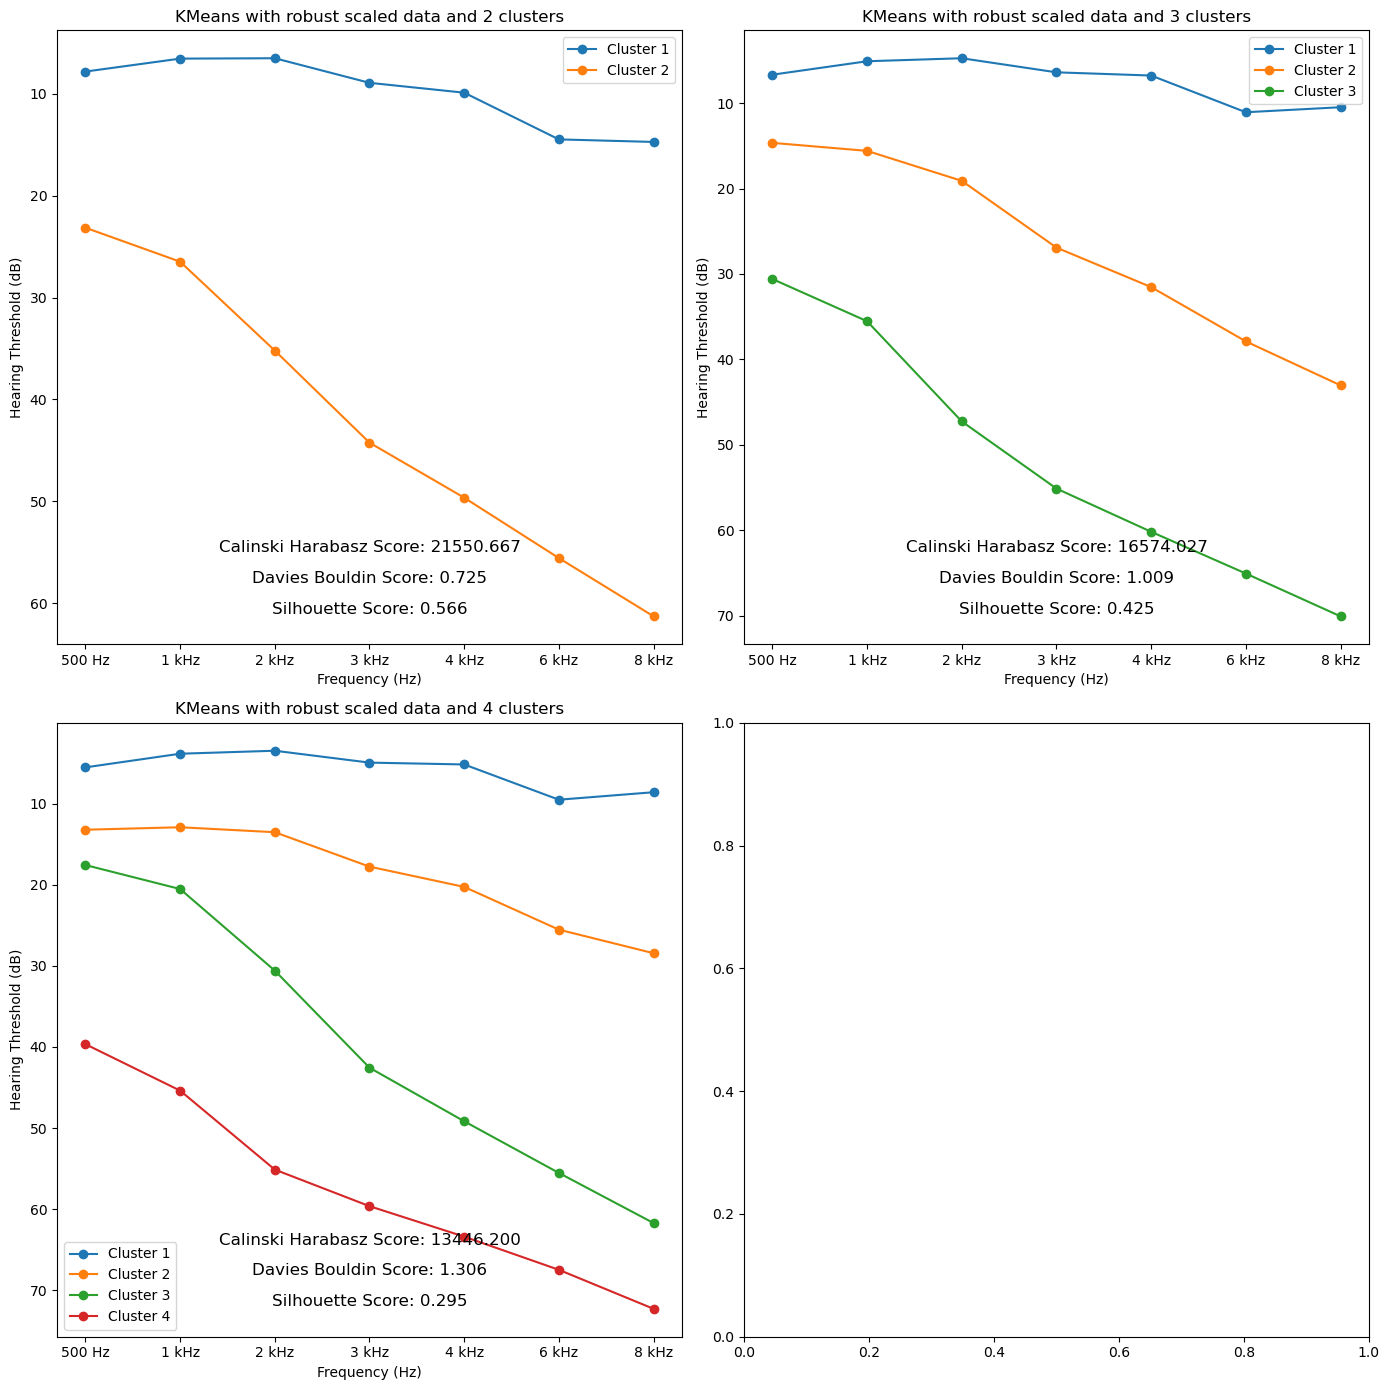

In [10]:
# K-Means with robust standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(robust_scaled_data)

    # Extract the centroids
    centroids = robust_scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with robust scaled data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

## K-Mean clustering with QuantileTransformed

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 2 clusters
Silhouette Score: 0.443
Davies Bouldin Score: 0.896
Calinski Harabasz Score: 16721.661
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 3 clusters
Silhouette Score: 0.225
Davies Bouldin Score: 1.199
Calinski Harabasz Score: 14650.235
--------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


KMeans with 4 clusters
Silhouette Score: 0.144
Davies Bouldin Score: 1.493
Calinski Harabasz Score: 11756.893
--------------------------------------------------


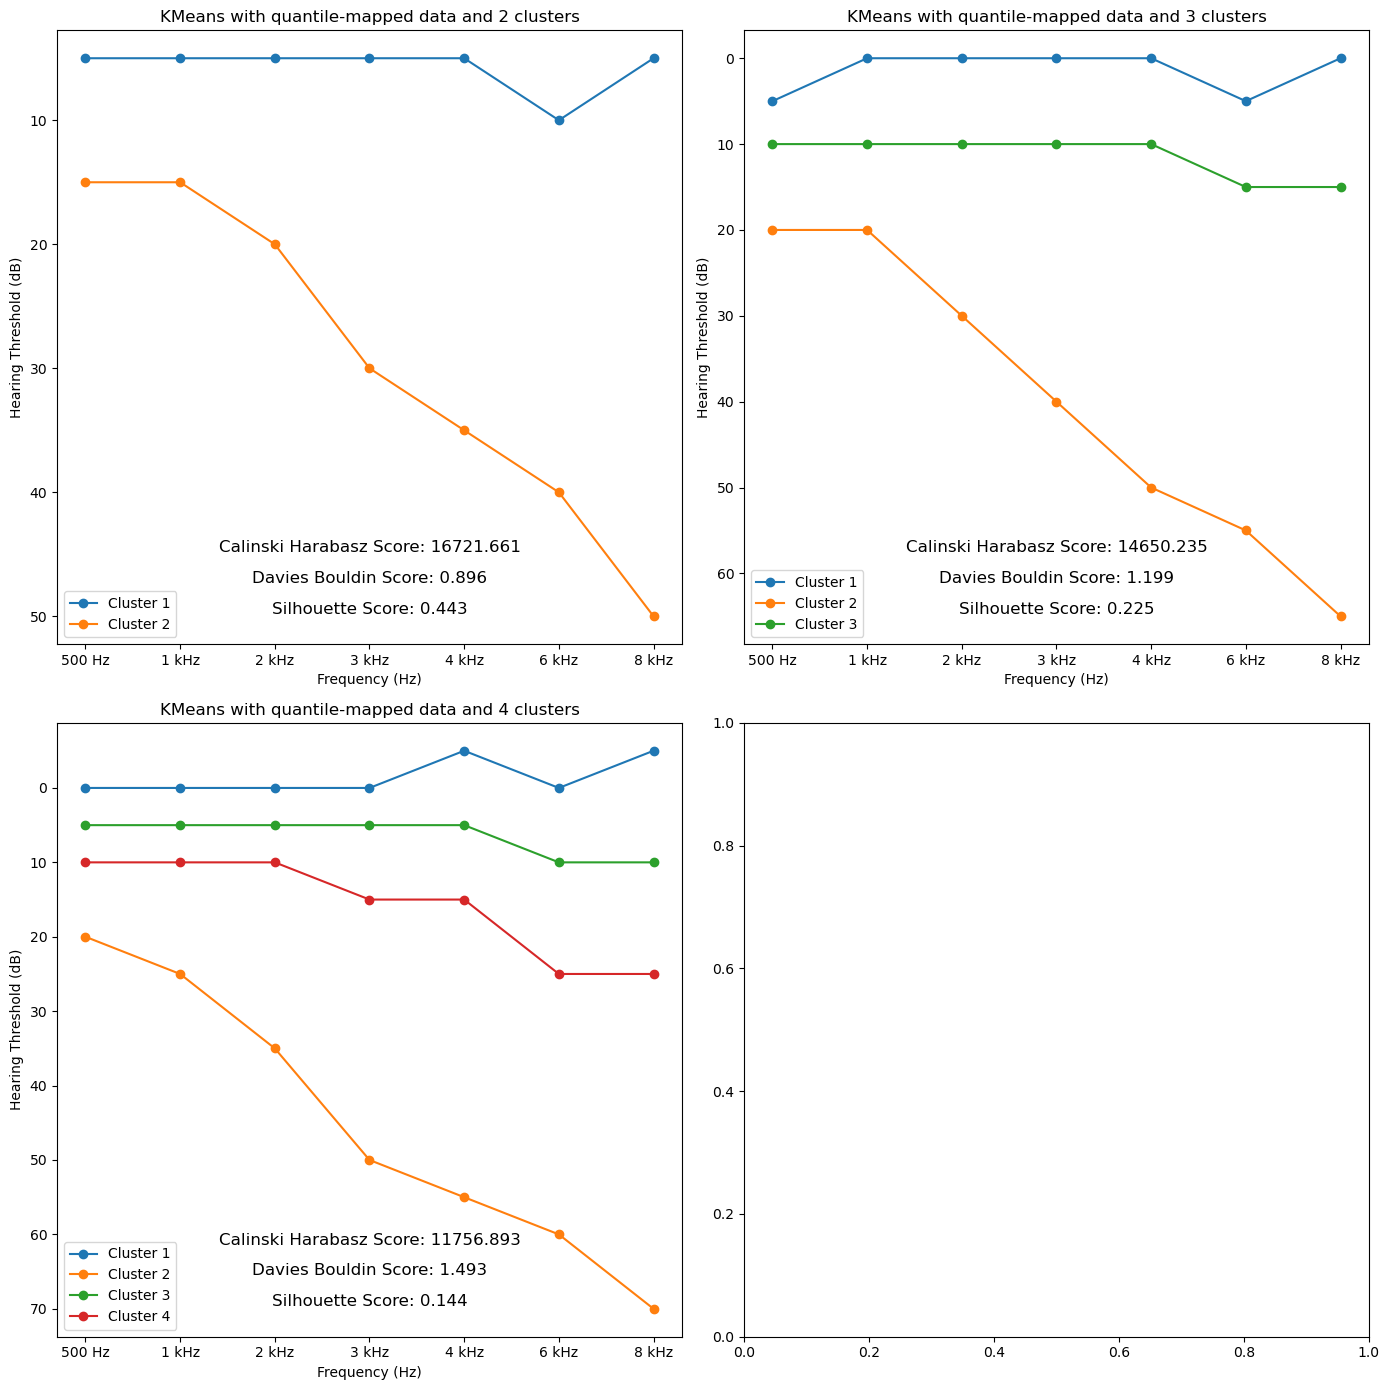

In [11]:
# K-Means with quantile standardized data

# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(quantile_transformed_data)

    # Extract the centroids
    centroids = quantile_transformer.inverse_transform(kmeans.cluster_centers_)
    centroids_df = pd.DataFrame(centroids, columns=ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with quantile-mapped data and {i} clusters')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=12)
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=12)
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()